<a href="https://colab.research.google.com/github/muschi-lab/climate_spectra_tutorial/blob/main/spectral_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectral Analysis of Climate Data

##  Fundamentals of Signal Processing | Fourier Transform | Periodogram | Red Noise and Autocorrelation | Significance Testing | Bandpass Filtering |

---

This tutorial explores spectral analysis techniques for climate data using Python. It covers fundamental concepts like the Fourier Transform and the periodogram for identifying periodic components in climate timeseries. Next, the tutorial addresses the impact of red noise, which commonly affects climate data, and demonstrates how to assess the significance of spectral peaks using Monte Carlo simulations. Finally, it illustrates techniques like bandpass filtering to isolate specific frequency ranges.

---
We'll use our familiar Python toolkits: NumPy (https://numpy.org/), and Matplotlib (https://matplotlib.org/).  Today, we'll familiarize with signal processing toolbox scipy.signal, which provides functions for estimating Power Spectra and Bandpass Filtering. The two key functions that we will be using today are the `periodogram` and the `butter` functions. If you are interested to know more about the `scipy.signal` library, its functions and their functionalities look at this [documentation](https://docs.scipy.org/doc/scipy/reference/signal.html) and the Appendix.

By the end of this tutorial + associated problem set, the aim is for you to feel more confident approaching spectral analysis techniques to query climate and paleoclimate timeseries.

---

Author: Francesco Muschitiello (fm476), Feb 2025.

---


## Import Libraries

In [1]:
## As always, for all your computing needs
import numpy as np

## For all things plotting
import matplotlib.pyplot as plt

## ipywidgets may require installation
!pip install ipywidgets
# for implementing a widget tool
import ipywidgets as widgets

## For reproducibility of random number generation
import random

## And, let's mount our Google Drive, as we are loading external files
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
Mounted at /content/drive


# Demo 1: Fundamentals of Spectral Analysis

## **Spectral Analysis**
Spectral analysis is a powerful tool that is widely used in climate science to break down climate timeseries into their fundamental periodic components. Think of it as tuning into different "musical instruments" within an orchestra —each frequency corresponds to a specific instrument, and spectral analysis reveals which ones are most prominent during a concert. This technique is especially useful for understanding and quantifying natural cycles in the climate system and is commonly applied to paleoclimatic records.


The fundamental idea behind spectral analysis is that a timeseries can be expressed as a convolution of sinusoids using the Fourier Transform.
In other terms, any time series $f(t)$ can be represented as a sum (or integral) of sinusoidal components with different frequencies, amplitudes, and phases. The Fourier Transform scans through all frequencies, checking how much of each one is present, and the result is like a **"frequency fingerprint"** of the signal.

---

### Visualizing Frequency Decomposition

The interactive snippet below shows how a signal can be represented as the sum of sinusoidal components. Here you can adjust two sine waves (their constituent characteristics, i.e. amplitude, frequency, and phase) to see how they sum into a complex signal. But before we play with it let's have a look at how a general sine equation look like.

$$
y(t) = A \sin(\frac{2 \pi}{T} t + \phi)
$$

where:
-  $A$ is the **amplitude** of the sinusoid
-  $T$ is its **period**
-  $t$ is the **time** variable
-  $\phi$ (phi) is the **phase shift** (how far the wave is shifted in time)

Remember, frequency ($f$) and period ($T$) are inversely related:

$$
f = \frac{1}{T}
$$

In [2]:
## For displaying widgets
from IPython.display import display

## Time setup
t = np.linspace(0, 10, 1000)  # 10 seconds of time

## Function to update plot
def update_plot(A1, f1, phi1, A2, f2, phi2):
    wave1 = A1 * np.sin(2 * np.pi * f1 * t + phi1)
    wave2 = A2 * np.sin(2 * np.pi * f2 * t + phi2)
    combined_wave = wave1 + wave2

    plt.figure(figsize=(10, 4))
    plt.plot(t, combined_wave, label="Sum of Sinusoids", color='b')
    plt.plot(t, wave1, '--', label=f"Wave 1: {f1} Hz", color='purple', alpha=0.7)
    plt.plot(t, wave2, '--', label=f"Wave 2: {f2} Hz", color='red', alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title("Signal Decomposition")
    plt.legend()
    plt.grid()
    plt.show()

## Create sliders (the entries define amplitude A, frequency f and phase phi of each sinusoid)
A1_slider = widgets.FloatSlider(value=1, min=0, max=2, step=0.1, description="A1")
f1_slider = widgets.FloatSlider(value=1, min=0.1, max=5, step=0.1, description="f1")
phi1_slider = widgets.FloatSlider(value=0, min=0, max=2*np.pi, step=0.1, description="phi1")

A2_slider = widgets.FloatSlider(value=0.5, min=0, max=2, step=0.1, description="A2")
f2_slider = widgets.FloatSlider(value=2, min=0.1, max=5, step=0.1, description="f2")
phi2_slider = widgets.FloatSlider(value=0, min=0, max=2*np.pi, step=0.1, description="phi2")

## Display interactive plot
display(widgets.interactive(update_plot, A1=A1_slider, f1=f1_slider, phi1=phi1_slider,
                    A2=A2_slider, f2=f2_slider, phi2=phi2_slider))


interactive(children=(FloatSlider(value=1.0, description='A1', max=2.0), FloatSlider(value=1.0, description='f…

## **Fourier Transform Equation**

The Fourier Transform of a function $f(t)$ can be expressed as:

$$
F(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i\omega t} dt
$$

The equation above converts a signal $f(t)$ from the time-domain into its frequency-domain representation $F(\omega)$. $F(\omega)$ provides information about the signal's constituent frequencies ($\omega$), their amplitudes ($A$), and phase offsets ($\phi$).

Let's break down the equation into its fundamental components.

---

### 1. $f(t)$ – The Original Signal
- This is the function we want to analyze and it represents how the signal changes over time.  

Again, think of it as an orchestra concert made of different instruments (frequencies), and we want to figure out what instruments are playing.

---

### 2. $e^{-i\omega t}$ – The Sinusoidal Components
- This is a **complex exponential** function, which is just a combination of sine and cosine:

  $$
  e^{-i\omega t} = \cos(\omega t) - i\sin(\omega t)
  $$

- The idea is that every signal can be **decomposed into a sum of sine waves** with different frequencies $\omega$, where $e^{-i\omega t}$ isolates the part of $f(t)$ oscillating at frequency $\omega$.

Imagine you’re listening to the orchestra and trying to hear only the violin section. This term helps “tune in” to specific instruments (frequencies).

---

### 3. The Integral $\int_{-\infty}^{\infty}$ – Summing Up Contributions
- The integral **adds up** how much of the frequency $\omega$ is present in $f(t)$, i.e. it slides across time and checks how well $f(t)$ matches the frequency component $e^{-i\omega t}$.

Think of it as a **radio tuner**—as you listen through different instruments (frequencies), you find the ones that are louder and the ones that are less prominent.

---

## **Continuous versus Discrete Fourier Transform**
The Fourier Transform exists in two main forms, **continuous and discrete**. For **continuous signals**, we use the integral-based Fourier Transform described above, which is called **Continuous Fourier Transform (CFT)**.

- The CFT assumes the signal $f(t)$ is defined for all real numbers.
- It is used in **mathematical analysis** and physics, and suitable for idealized, infinite signals.

### Discrete Fourier Transform (DFT)
For **discrete signals**, such as climate timeseries, we use the **Discrete Fourier Transform (DFT)**.

- This assumes we only have a **finite set of samples** (like climate data).
- Used in **digital signal processing, audio processing, and climate data analysis**.

---

### Why Do We Use the DFT in practice?
Since most real-world data (e.g. climate timeseries) is **discretely measured**, we **approximate the Fourier Transform using the DFT**. In this tutorial we will focus on DFT computations using the Fast Fourier Transform (FFT), which is a faster, and more efficient version of the DFT, and widely used for spectral analysis. We will use the function `periodogram` from the library `scipy.signal`.

---


### Other Spectral Methods

There are several other methods for estimating the spectral properties of a timeseries, each with its strengths and limitations. Depending on the data type, resolution, and computational needs, different techniques might be more suitable. Something to bear in mind is that the **most spectral methods (including DFT/FFT) rely on the assumption that the data is evenly sampled** (i.e. uniform time spacings between adjacent observations). This is not always be the case, especially if we are dealing with paleoclimatic data, so you may want appropriately interpolate your data prior to spectral analysis.

| Method                         | Strengths                                                            | Limitations                                               |
|--------------------------------|----------------------------------------------------------------------|-----------------------------------------------------------|
| **Welch's Periodogram**        | - Reduces noise by averaging over overlapping segments.               | - Resolution can be limited by segment length.             |
|                                | - Efficient for evenly spaced data.                                  | - May lose information due to segment averaging.           |
| **Multi-Taper Method (MTM)**   | - Reduces variance of spectral estimates using multiple tapers.      | - Computationally more intensive due to multiple tapers.  |
|                                | - Useful for smooth spectral estimates.                              | - May require choosing the appropriate number of tapers.   |
| **Lomb-Scargle Periodogram**   | - Effective for unevenly spaced datasets.                            | - Can be computationally expensive for large datasets.    |
|                                | - Flexible with different windows and segmentation options.          | - May still suffer from limitations when spacing is highly irregular. |
| **Weighted Wavelet Z-Transform** | - Excellent for unevenly spaced data, captures non-stationary signals. | - Computationally demanding, especially with large datasets. |

---

---

# Demo 2: Analyzing a Climate Timeseries

## **Synthetic Climate Data**

Now that we've explored the fundamentals of the Fourier Transform, let's apply it to some climate data. Climate timeseries often exhibit variability on multiple timescales, e.g. seasonal, interannual, decadal, and even centennial trends. By using Fourier analysis, we can identify dominant frequencies and distinguish periodic signals from long-term trends.

To illustrate how different climate cycles combine, **we create a synthetic climate timeseries** $y(t)$ that includes:

- **Annual variability**
- **Interannual variability** (e.g. ENSO)
- **Multidecadal variability** (e.g. AMO)
- **Centennial trend** (e.g., long-term warming)

Following the general sine equation presented in *Demo 1*, the synthetic timeseries can be expressed:

$$
y(t) = A_1 \sin\left( \frac{2\pi}{T_1} t + \phi_1 \right) +
       A_2 \sin\left( \frac{2\pi}{T_2} t + \phi_2 \right) +
       A_3 \sin\left( \frac{2\pi}{T_3} t + \phi_3 \right) +
       \beta t + \epsilon(t)
$$

where:

- $( A_1, A_2, A_3 $) are the amplitudes of the cycles,
- $( T_1 = 1 $) is the annual cycle in year,
- $( T_2 = 5 $) is the interannual cycle in years,
- $( T_3 = 50 $) is the multidecadal cycle in years,
- $( \phi_1, \phi_2, \phi_3 $) are the phase shifts of the cycles,
- $( \beta $) represents a long-term linear trend (e.g., warming),
- $( \epsilon(t) $) is random Gaussian noise simulating unpredictable variations.

### Generate Synthetic Climate Timeseries

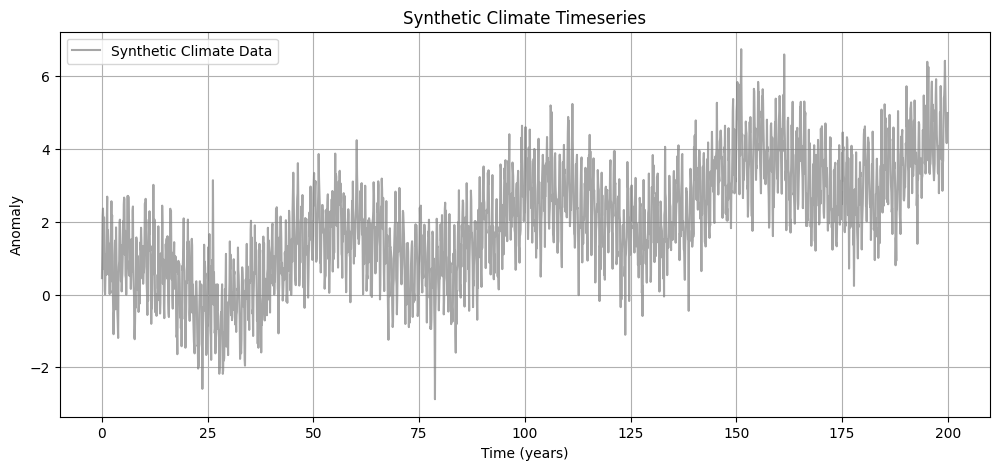

In [3]:
# Time setup: 200 years of monthly data
years = 200
dt = 1/12  # Monthly time step
t = np.arange(0, years, dt) # time points for the synthetic data

# Define signal components
# 'A' represents the amplitude of each cycle, 'T' represents the period (in years), and 'phi' represents the phase shift
A1, T1, phi1 = 1, 1, 0      # Seasonal cycle (1-year period, no phase shift)
A2, T2, phi2 = 0.5, 5, np.pi/4    # Interannual variability (5-year period, phase shift of pi/4)
A3, T3, phi3 = 0.9, 50, np.pi/3   # Decadal variability (50-year period, phase shift of pi/3)
trend_slope = 0.02 # Centennial trend

# Generate the components following the general sine equation
seasonal_cycle = A1 * np.sin(2 * np.pi * t / T1 + phi1)
interannual_cycle = A2 * np.sin(2 * np.pi * t / T2 + phi2)
decadal_cycle = A3 * np.sin(2 * np.pi * t / T3 + phi3)
centennial_trend = trend_slope * t

# Normal noise (mean = 0; standard deviation = 1)
noise = 0.5 * np.random.randn(len(t))
# Note that the noise is here scaled to have a given standard deviation relative to the unit amplitude.

# Combine all components
synthetic_data = seasonal_cycle + interannual_cycle + decadal_cycle + centennial_trend + noise

# Plot time series
plt.figure(figsize=(12, 5))
plt.plot(t, synthetic_data, label="Synthetic Climate Data", color='gray', alpha=0.7)
plt.xlabel("Time (years)")
plt.ylabel("Anomaly")
plt.title("Synthetic Climate Timeseries")
plt.legend()
plt.grid()
plt.show()

### Calculate the Periodogram

<ipython-input-4-1bc0098c0b54>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
<ipython-input-4-1bc0098c0b54>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


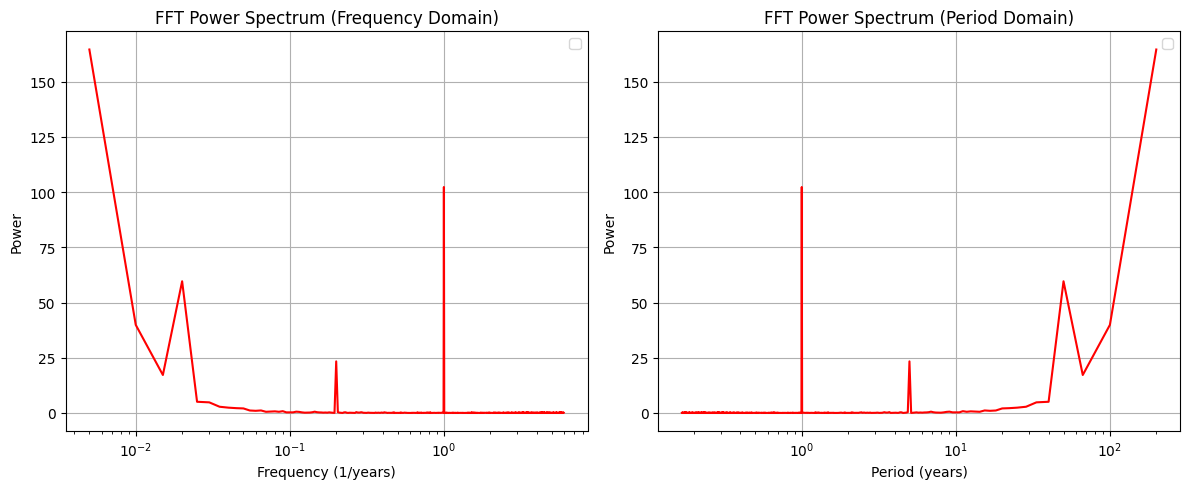

In [4]:
# Import Periodogram function
from scipy.signal import periodogram

# Code to Compute Periodogram (Power Spectral Density)
f, Pxx = periodogram(synthetic_data, fs=1/dt)  # Periodogram function (see Appendix for details)

# Convert frequency to period
positive_freqs = f[f > 0]  # Remove the zero frequency component
positive_power = Pxx[f > 0]
periods = 1 / positive_freqs  # Period is the inverse of frequency

# Plot Periodogram Power Spectrum with Frequency and Period side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

## Let's plot the periodogram in both the frequency and period domain.
# Frequency domain plot
axes[0].semilogx(positive_freqs, positive_power, color='r')
axes[0].set_xlabel("Frequency (1/years)")
axes[0].set_ylabel("Power")
axes[0].set_title("FFT Power Spectrum (Frequency Domain)")
axes[0].legend()
axes[0].grid()

# Period domain plot
axes[1].semilogx(periods, positive_power, color='r')
axes[1].set_xlabel("Period (years)")
axes[1].set_ylabel("Power")
axes[1].set_title("FFT Power Spectrum (Period Domain)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

### Some Considerations

Note the well-defined annual, 5-year and 50-year periodicities in the synthetic timeseries. Obviously, this is not a realistic simulation of how a real climate data set looks like. Adding more noise can help make it more realistic as this mimics random variability found in the climate system.

---
**_Aside_**: *Let's play with the noise scaling factor and observe how the timeseries and power spectra change. For example try re-running the previous chunk by changing the value from 0.5 to 2.5. Can you still visually identify periodicities <10 years?*

---

# Demo 3: Understanding and Testing for Stationarity

## **Stationarity Test**

Bear in mind that **the DFT assumes signals are stationary** and does not account for frequency changes over time. This makes it somewhat less effective for non-stationary signals. What does stationary mean? It means that **the statistical properties of our timeseries, i.e. mean, variance, and autocorrelation structure (more on this later), don't change over time**. Thus, it is always useful to check for stationarity using for example the Augmented Dickey-Fuller (ADF) test.

**If the data are non-stationary, you may need to transform the timeseries** to make it stationary. Commonly we transform the data using log-transformation or linear detrending. In our specific case we could remove a linear trend from the data by using the argument `detrend='linear'` in the `periodogram` function. Truth be told, **most of the time we can get away with quasi-stationarity**, especially when the periodic signal doesn't exhibit dramatic shifts over time.

Let's check that our climate timeseries is stationary by running an ADF test (a non-significant p-value indicates non-stationarity!). Obviously our timeseries is highly idealized and we already know that the frequencies are stationary, but the fact that there is a linear warming trend may affect its spectral properties, so it's worth running the test.

### ADF Test of Stationarity

In [5]:
# Import function for ADF test
!pip install statsmodels
from statsmodels.tsa.stattools import adfuller

result = adfuller(synthetic_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 15.0 MB/s eta 0:00:00
ADF Statistic: -2.210669097862199
p-value: 0.2023960033672223


*Our data did not pass the stationarity test. It seems that we have to linearly detrend our timeseries.*

---
**_Aside_**: *Once again, let's play with the noise scaling factor and observe how the p-value change. Re-run the ADF test by gradually increasing the value. How much noise is needed before the data passes the test?
Also, re-run the periodogram after detrending the data by using the argument `detrend='linear'` in the `periodogram` function. How does the new spectrum look like?*

---

# Demo 4: Exploring Red Noise and Autocorrelation

## **Memory in the Climate System**

**The climate system exhibits persistence and contains many sources of inertia or ‘memory’**. As a result, climate timeseries exhibit different degrees of **temporal autocorrelation**, meaning that current climate states are influenced by past events.

![memory](https://drive.google.com/uc?export=view&id=1mJ3ufT8selxhZx5NHmlwErKXQc2sPzY1)
*Courtesy of Stephen Meyers*

For instance, temperature tends to change faster on land (or in the atmosphere) than in the ocean due to the slow response time of the oceans, which store heat for extended periods. This **thermal 'memory' smooths out short-term fluctuations and introduces persistence** in the resulting climate timeseries.

This phenomenon allows for some predictability in climate patterns beyond short-term weather fluctuations, thus making climate memory an actively discussed topic in climate sciences.

---

### From Persistence to Red Noise: Climate as a Random Walk
Because climate variables don’t fluctuate independently from one moment to the next, they behave more like a **random walk** rather than pure white (i.e. Gaussian) noise, that is completely uncorrelated noise.

- **White noise** is like flipping a coin: Each new outcome is independent of the past.  
- **Red noise (random walk behavior)** is like measuring atmospheric $CO_2$: Today's value depends on yesterday's, plus some random influence.

A simple mathematical way to represent this is through an **autoregressive process –also known as AR(1) process**, where today's climate state depends partly on yesterday’s state plus some random forcing:

$$
X_t = \alpha X_{t-1} + \epsilon_t
$$

where:
- $( X_t $) is the climate variable at time $( t $),
- $( \alpha $) is a value between 0 and 1 and reflects the persistence (higher values mean stronger memory),
- $( \epsilon_t $) is random noise.

If **$( \alpha $) is close to 1**, the system behaves like a **random walk**, meaning changes are **cumulative and persistent** over long timescales.

---

### Implications for Climate Timeseries
1. **Long-Term Dependence:**  
   - If climate noise were purely white noise, we wouldn’t see trends over time.  
   - Because of persistence, the climate system **integrates past fluctuations**, making trends more likely over time.  

2. **Spectral Characteristics of Climate Noise:**  
   - White noise has a **flat power spectrum** (equal energy at all frequencies).  
   - Red noise shows **more power at low frequencies**, meaning **longer-term fluctuations dominate** over short-term variability.  

---

### Spectral Characteristics of White and Red Noise

*Let's generate two timeseries, one that is purely gaussian (white) noise, and one random walk (red noise). We will then compare their spectral characteristics.*

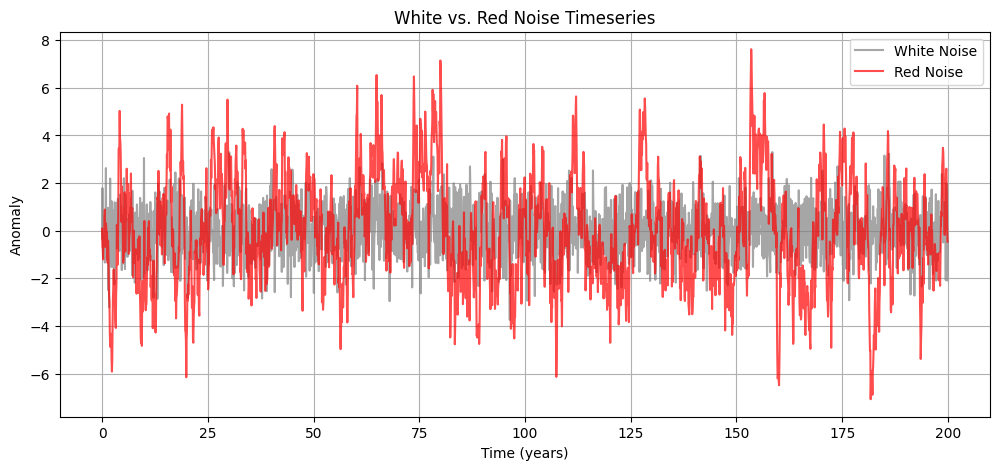

In [6]:
# Set parameters
years = 200
dt = 1/12  # Monthly time step
t = np.arange(0, years, dt) # time points for the synthetic data
N = len(t) # Length of the time vector

# Generate white (uncorrelated) noise
white_noise = np.random.randn(N)

# Generate red noise (AR(1) process)
alpha = 0.9  # Persistence parameter for red noise
red_noise = np.zeros(N)
for i in range(1, N):
    red_noise[i] = alpha * red_noise[i-1] + np.random.randn()

# Convert to anomalies, i.e. center both white and red noise to have mean 0
white_noise -= np.mean(white_noise)
red_noise -= np.mean(red_noise)

# Plot White vs Red Noise Time Series
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(t, white_noise, label="White Noise", color='gray', alpha=0.7)
ax.plot(t, red_noise, label="Red Noise", color='red', alpha=0.7)
ax.set_xlabel("Time (years)")
ax.set_ylabel("Anomaly")
ax.set_title("White vs. Red Noise Timeseries")
ax.legend()
ax.grid()

### Some Considerations

Note how the simulated dependence in the random walk provides some consistency from step-to-step (red timeseries) rather than the large jumps that independent, gaussian numbers provide (gray timeseries).

---
*Now let's calculate the periodogram of both signals. Personally, I like plotting spectra on a log-Period scale but feel free to adopt whichever plotting strategy you see fit.*

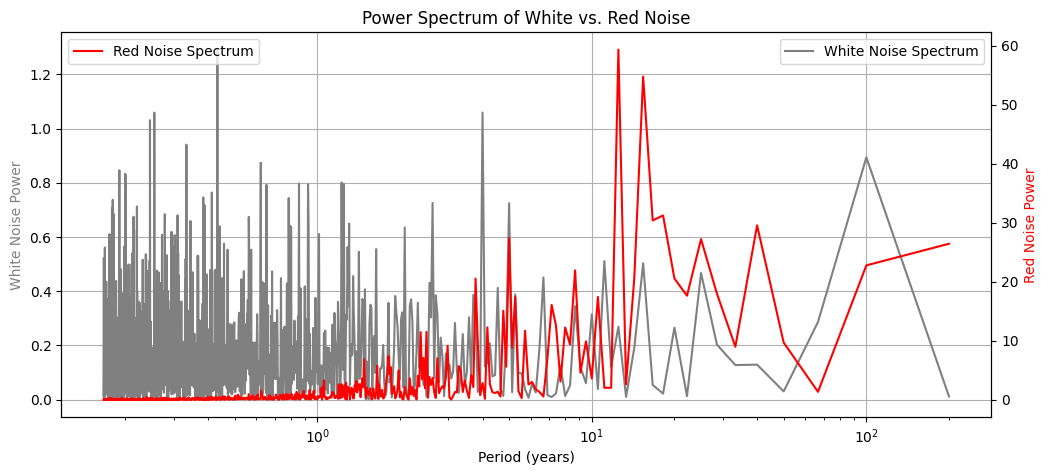

In [7]:
# Import Periodogram function
from scipy.signal import periodogram

# Compute Power Spectra
f, Pxx_white = periodogram(white_noise, fs=1/dt)
f, Pxx_red = periodogram(red_noise, fs=1/dt)

# Convert frequency to period
periods = 1 / f[1:]  # Avoid division by zero

# Plot Power Spectrum with Separate Y-Axes
fig, ax1 = plt.subplots(figsize=(12, 5))
ax2 = ax1.twinx()
ax1.semilogx(periods, Pxx_white[1:], label="White Noise Spectrum", color='gray')
ax2.semilogx(periods, Pxx_red[1:], label="Red Noise Spectrum", color='red')

ax1.set_xlabel("Period (years)")
ax1.set_ylabel("White Noise Power", color='gray')
ax2.set_ylabel("Red Noise Power", color='red')
ax1.set_title("Power Spectrum of White vs. Red Noise")
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
ax1.grid()

### Some Considerations

By comparing the spectra of the two timeseries we note that greater temporal autocorrelation (i.e., greater “memory”), implies that most of the variation in the timeseries is driven by low frequencies. In fact, **the spectral density of a random walk is inversely proportional to its frequency, meaning it has more energy at lower frequencies**.

---
*We will now calculate the autocorrelation function (ACF) of both signals. The ACF is is defined as the correlation of a signal with a lagged copy of itself as a function of lag.*

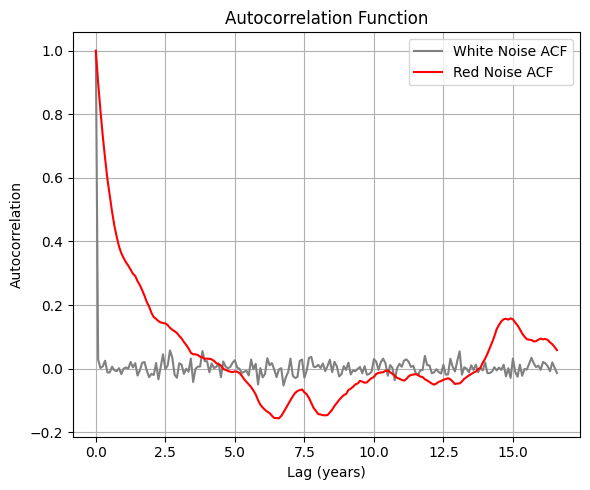

In [8]:
# Import Correlate function (used for calculating autocorrelation)
from scipy.signal import correlate

## Defining a function to compute the Autocorrelation Function (ACF)
# The function takes a signal and the max_lag as input, and it uses the correlate function to compute cross-correlation of the signal with itself. It then returns for each lag the correlation coefficients.
def compute_acf(signal, max_lag):
    acf = correlate(signal, signal, mode='full')
    acf = acf[len(acf)//2:]  # Keep only positive lags
    acf /= acf[0]  # Normalize
    return acf[:max_lag]

max_lag = 200  # Set max lag for ACF
acf_white = compute_acf(white_noise, max_lag)
acf_red = compute_acf(red_noise, max_lag)
lags = np.arange(max_lag) * dt  # Convert to years
# Plot Autocorrelation Function (ACF) on the Same Graph
fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(lags, acf_white, label="White Noise ACF", color='gray')
ax.plot(lags, acf_red, label="Red Noise ACF", color='red')
ax.set_xlabel("Lag (years)")
ax.set_ylabel("Autocorrelation")
ax.set_title("Autocorrelation Function")
ax.legend()
ax.grid()

plt.tight_layout()
plt.show()

### Some Considerations

Finally, note how **the autocorrelation functions** of the white and red noise timeseries differ. The ACF is defined as the correlation of a signal with itself as a function of the lag. **The amount of time that it takes the autocorrelation function to reach a value near zero indicates how much ‘memory’ a system exhibits**.

---
**_Aside_**: *Try re-running the previous chunk, but now raising the persistence parameter $\alpha$* to 0.95 or 0.99.

---

### The Real World Includes Both White and Red Noise

*Let's go back to our synthetic climate timeseries. We will now generate the same data again, but this time with a mix of short-term (white noise) and long-term (red noise) fluctuations, so that the variability is more realistic.*

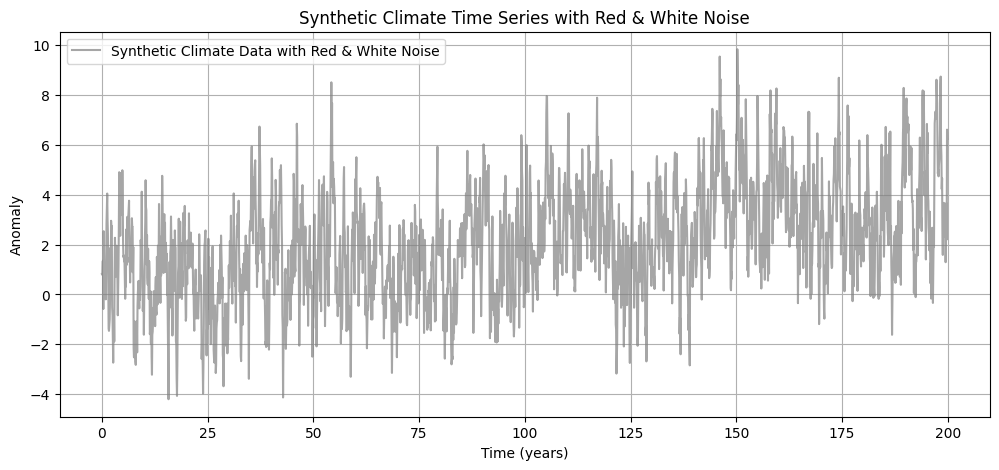

In [9]:
# Set the seed for reproducibility
random.seed(39)

# Time setup: 200 years of monthly data
years = 200
dt = 1/12  # Monthly time step
t = np.arange(0, years, dt)
N = len(t)

# Define components
A1, T1, phi1 = 1, 1, 0      # Seasonal cycle (1-year period, no phase shift)
A2, T2, phi2 = 0.5, 5, np.pi/4    # Interannual variability (5-year period, phase shift of pi/4)
A3, T3, phi3 = 0.9, 50, np.pi/3   # Decadal variability (50-year period, phase shift of pi/3)
trend_slope = 0.02 # Centennial trend

# Generate the components
seasonal_cycle = A1 * np.sin(2 * np.pi * t / T1 + phi1)
interannual_cycle = A2 * np.sin(2 * np.pi * t / T2 + phi2)
decadal_cycle = A3 * np.sin(2 * np.pi * t / T3 + phi3)
centennial_trend = trend_slope * t

# Generate White Noise
white_noise = 0.5 * np.random.randn(len(t))  # Scaling white noise for variability

# Generate Red Noise using an AR(1) process
alpha = 0.8  # Persistence parameter for red noise
red_noise = np.zeros(N)
for i in range(1, N):
    red_noise[i] = alpha * red_noise[i-1] + np.random.randn()

# Combine all components with both white and red noise
synthetic_data = seasonal_cycle + interannual_cycle + decadal_cycle + centennial_trend + red_noise + white_noise

# Plot time series
plt.figure(figsize=(12, 5))
plt.plot(t, synthetic_data, label="Synthetic Climate Data with Red & White Noise", color='gray', alpha=0.7)
plt.xlabel("Time (years)")
plt.ylabel("Anomaly")
plt.title("Synthetic Climate Time Series with Red & White Noise")
plt.legend()
plt.grid()
plt.show()

*And now we will estimate and plot the spectrum on the frequency and period scale, respectively. Remember that depending on the amount of noise we will need to detrend the data or not.*

<ipython-input-10-f1efeb9bd9e0>:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()
<ipython-input-10-f1efeb9bd9e0>:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()


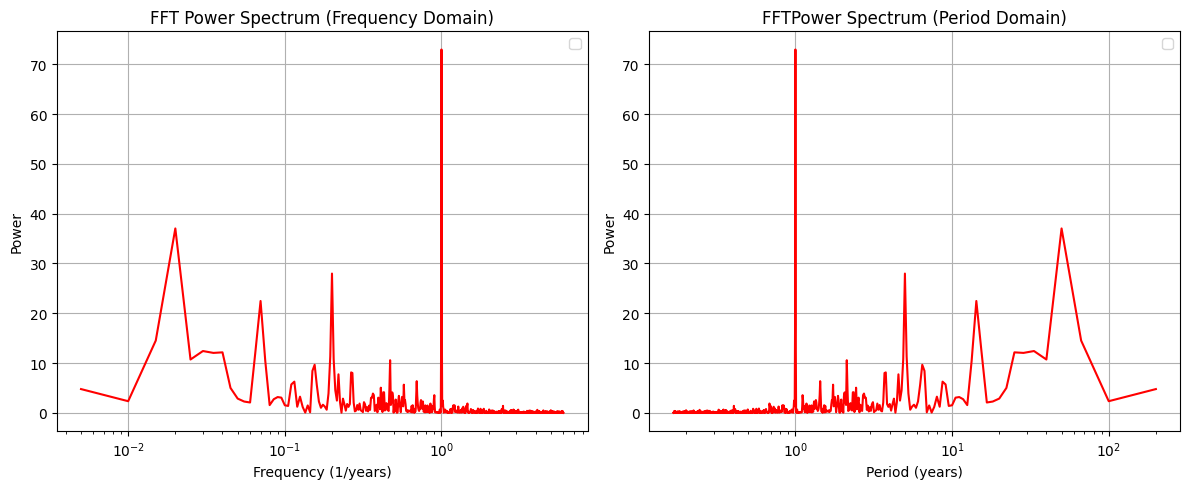

In [10]:
# Import Periodogram function
from scipy.signal import periodogram

# Compute Periodogram (Power Spectral Density) with or without detrending (uncomment/comment lines below as appropriate)
# f, Pxx = periodogram(synthetic_data, fs=1/dt, window = 'hann')  # Periodogram function
f, Pxx = periodogram(synthetic_data, fs=1/dt, window = 'hann', detrend = 'linear')  # Periodogram function with linear detrending

# Convert frequency to period
positive_freqs = f[f > 0]  # Remove the zero frequency component
positive_power = Pxx[f > 0]
periods = 1 / positive_freqs  # Period is the inverse of frequency

# Plot Periodogram Power Spectrum with Frequency and Period side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Frequency domain plot
axes[0].semilogx(positive_freqs, positive_power, color='r')
axes[0].set_xlabel("Frequency (1/years)")
axes[0].set_ylabel("Power")
axes[0].set_title("FFT Power Spectrum (Frequency Domain)")
axes[0].legend()
axes[0].grid()

# Period domain plot
axes[1].semilogx(periods, positive_power, color='r')
axes[1].set_xlabel("Period (years)")
axes[1].set_ylabel("Power")
axes[1].set_title("FFTPower Spectrum (Period Domain)")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

---
**_Aside_**: *Let's play with the normal noise scaling factor and the persistence parameter $\alpha$ and observe how different levels of white and red noise impact the spectral signatures. Additionally, check the effect of removing the warming trend on the power spectrum (this is easily done by setting the argument *detrend='linear'* in the `periodogram` function.).*

---

# Demo 5: Significance Testing and Windowing

## **Significance Testing in the Presence of Red Noise**

At this point you will have probably noticed that the power spectra exhibit some peaks, especially at low frequencies that that were NOT used to construct our synthetic timeseries. This begs the question as to **how we can estimate the significance of the annual, 5-year and 50-year cycles in the presence of red noise?**

To prevent false detections and test the significance of the cycles in our synthetic climate timeseries, we need to **determine whether the spectral peaks are statistically significant compared to a red noise null hypothesis**.

There are different ways to estimate the statistical significance of spectral peaks, each one with its strengths and limitations. A widely used approach to assessing the significance of frequency peaks in timeseries that are affected by red noise typically involves the following steps:

  1. Fit an AR(1) red noise model to the observed timeseries.
  2. Compute the **theoretical red noise spectrum**.
  3. Determine confidence levels (e.g. 90% or 95%) using Monte Carlo simulations of red noise stemming from the theoretical spectrum.

First of all, what is the theoretical red noise spectrum? In simple terms it's a statistical model for our climate timeseries assuming that our observed data follows an AR(1) process. The theoretical red noise spectrum of an AR(1) process can be expressed as follows:

$$
S(f) = \frac{1-\alpha^2}{1-2\alpha\cos(2\pi f)+\alpha^2}.
$$

where:

- $S(f)$ represents the power of the red noise at a given frequency;
- $α\:$ is the autoregressive coefficient (estimated from the data's AR(1)), representing the persistence or "memory" of the red noise;
- $f$ is the frequency at which the power spectrum is being evaluated.

Based on the inferred theoretical red noise spectrum, we can simulate many synthetic timeseries with the same red noise properties as the observed timeseries.

Once we generated multiple realizations (e.g. 10,000) of synthetic AR(1) timeseries, we can compute their power spectra, and compute confidence intervals from the resulting ensemble (e.g. 95%).

Ultimately, we can compare the empirical spectrum to the red noise confidence levels. If an observed spectral peak exceeds the 95% confidence level, it's statistically significant.

---

### Applying Monte Carlo Simulation for Significance Testing

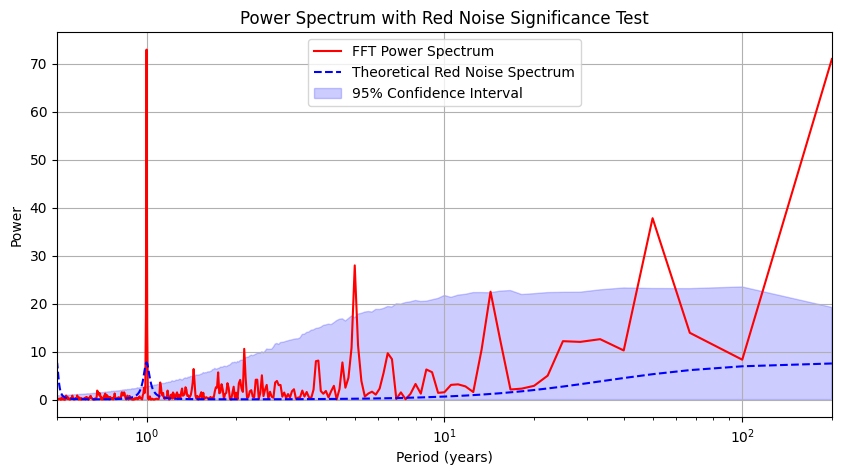

In [11]:
# Import Periodogram and lfilter functions. lfilter is used here to generate red noise (creates 'memory' from white noise)
from scipy.signal import periodogram, lfilter

dt = 1/12  # Monthly time step

# Compute Periodogram (Power Spectral Density) with or without detrending (uncomment/comment lines below as appropriate)
f, Pxx = periodogram(synthetic_data, fs=1/dt, window = 'hann')
# f, Pxx = periodogram(synthetic_data, fs=1/dt, window = 'hann', detrend = 'linear') # Periodogram function with linear detrending

# Estimate AR(1) parameter from our climate timeseries
acf_lag1 = np.corrcoef(synthetic_data[:-1], synthetic_data[1:])[0, 1]

# Compute theoretical red noise spectrum. This is the coded counterpart of the theoretical red noise spectrum equation presented above.
# It essentially models how the power of red noise decays across frequencies, given its persistence of the original data (i.e. its AR(1) coeff).
red_spectrum = (1 - acf_lag1**2) / (1 - 2 * acf_lag1 * np.cos(2 * np.pi * f) + acf_lag1**2)
# For statistical comparability, the spectrum is then normalized to have the same average power as the observed power spectrum
red_spectrum *= np.mean(Pxx) / np.mean(red_spectrum)

## Monte Carlo Significance Testing (10,000 synthetic realizations)
# Note that this is a 'loop' of 10,000 repetitions of the same set of actions: Step 1. create red noise with the same AR(1) coeff as your data; Step 2. calculate the periodogram; Step 3. normalize the periodogram
n_sims = 10000
simulated_spectra = np.zeros((n_sims, len(f)))
for i in range(n_sims):
    synthetic_red = lfilter([1], [1, -acf_lag1], np.random.randn(len(t)))  # Step 1
    # Note that the lfilter function takes white noise as input and applies a filter to introduce a dependence on the previous value of the signal, effectively converting the white noise into red noise
    _, simulated_spectrum = periodogram(synthetic_red, fs=1/dt, window = 'hann') # Step 2
    # _, simulated_spectrum = periodogram(synthetic_red, fs=1/dt, window = 'hann', detrend = 'linear') # Step 2 with detrend
    simulated_spectra[i, :] = simulated_spectrum * (np.mean(Pxx) / np.mean(simulated_spectrum))  # Step 3

# Compute 95% confidence interval from Monte Carlo simulations
conf95 = np.percentile(simulated_spectra, 95, axis=0)

# Convert frequency to period for plotting
periods = 1 / f[1:]  # Avoid division by zero

# Plot Power Spectrum and Red Noise Confidence Interval
plt.figure(figsize=(10, 5))
plt.semilogx(periods, Pxx[1:], label="FFT Power Spectrum", color='r')
plt.semilogx(periods, red_spectrum[1:], label="Theoretical Red Noise Spectrum", color='blue', linestyle='dashed')
plt.fill_between(periods, 0, conf95[1:], color='blue', alpha=0.2, label="95% Confidence Interval")
plt.xlabel("Period (years)")
plt.ylabel("Power")
plt.title("Power Spectrum with Red Noise Significance Test")
plt.legend()
plt.grid()
# Set x-axis limits
plt.xlim(0.5, max(periods))  # Start from 0.5 years
plt.show()

We have successfully identified the annual, 5-year, and 50-year cycles, all of which stand out from the background red noise.

## **Spectral 'Leakage' and Windowing**

You may have noticed that **adding noise to your signal can affect frequency resolution and cause spectral leakage**, where power from one frequency spreads (or 'leaks') to neighboring frequencies. Harmonics of the primary frequency (i.e. integer multiples of the fundamental frequency) can also appear in the presence of noise, making them stand out more prominently.

**Leakage can also result from 'edge effects'**. What does that mean? Well, because of the discrete nature of our timeseries, we are likely dealing with **data containing frequencies that don't complete a whole number of cycles over the signal duration**. Remember that the Fourier Transform assumes the signal is periodic over the signal interval. As a result, the edges can thus cause discontinuities and introduce spectral leakage.

The good news is that **we can control leakage to direct the leaked energy by a technique called windowing**. The underlying idea is to force continuity at the edges of a signal, prior to performing the DFT. This approach **reduces the discontinuities at the edges of the data segment**, thus minimizing leakage into adjacent frequencies.

![windowing](https://drive.google.com/uc?export=view&id=10QTbCKZnxhDKww9colx8xU46CTu3kBal)

*Different choices of window function and the corresponding DFT magnitude spectrum after applying each window to a sinusoid that do not complete a whole number of cycles over the signal duration.*

---

By default, the `periodogram` function uses a rectangular (Boxcar) window, which offers good frequency resolution but doesn't minimize edge effects. Other windows include: *Hamming*, *Hann*, *Blackman-Harris*. Each window balances spectral leakage and frequency resolution differently.
    
Let's have a quick look at how different window choices affect our spectral resolution and leakage.

### Compare Windowing Functions

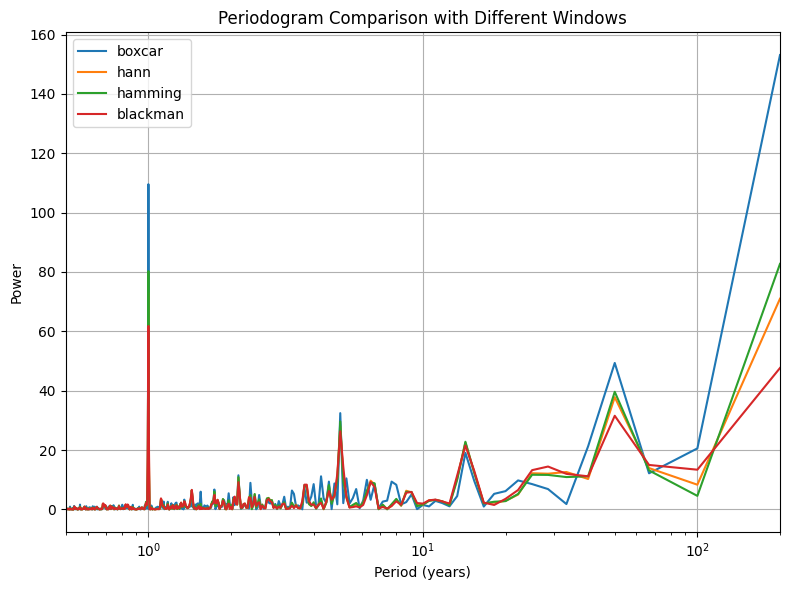

In [12]:
# Import Periodogram function
from scipy.signal import periodogram

# Compute Periodogram with different windowing functions and plot on the same axis
windows = ['boxcar', 'hann', 'hamming', 'blackman']
plt.figure(figsize=(8, 6))

# Run a loop to calculate and plot a periodogram for each windowing function
for window in windows:
    f, Pxx = periodogram(synthetic_data, fs=1/dt, window=window)

    positive_freqs = f[f > 0]  # Remove zero frequency component
    positive_power = Pxx[f > 0]

    # Convert frequency to period (period = 1 / frequency)
    periods = 1 / positive_freqs

    plt.semilogx(periods, positive_power, label=f"{window}")

# Formatting the plot
plt.xlabel("Period (years)")
plt.ylabel("Power")
plt.title("Periodogram Comparison with Different Windows")
plt.legend()
plt.grid()
plt.tight_layout()
# Set x-axis limits
plt.xlim(0.5, max(periods))  # Start from 0.5 years
plt.show()


### What Window shall we use?

**Boxcar Window:**
This is the simplest window. It doesn't apply any smoothing and results in the most spectral leakage. This is probably not the best choice for our data as it can distort the spectrum, especially in the presence of red noise and linear trends.

**Hann Window:**
This window is a good choice when we want to reduce spectral leakage, especially in the presence of red noise. It reduces the frequency resolution somewhat, but this is generally acceptable given that our signal comes with well-defined cycles. If our main goal is to have a clean spectrum with minimal leakage while maintaining reasonable frequency resolution, the Hanning window is the best trade-off.

**Hamming Window:**
Slightly less leakage than the Hann window, but at the cost of frequency resolution.

**Blackman Window:**
If your data contains a lot of red noise and spectral leakage is a real concern, the Blackman window is our best choice. The downside of it is a significant reduction in frequency resolution (i.e. broader peaks), which might make it harder to identify close frequency components.

**Conclusion:**
I'm going to make an executive call here and decide that the Hann window is the likely the most suitable method for my data, as it provides a good trade-off between minimizing leakage and maintaining frequency resolution.

---
**_Aside_**: *Examine how reliable this approach is as you gradually increase the amount of white and red noise, respectively. You will probably find that as the level of noise in the timeseries increases, the red noise significance test start failing at detecting spurious peaks in the power spectrum. This is an important consideration when analyzing real-world climate timeseries, where noise is often inevitable.*

---

# Demo 6: Bandpass Filtering for Isolating Cycles

## **Bandpass filtering**

Another widely used spectral techniques used in climate science is Bandpass Filtering. This technique is used to isolate a specific range of frequencies from a signal, and remove unwanted high-frequency noise and low-frequency trends trends outside of that range. It’s particularly useful in paleoclimate science to focus on processes occurring over specific timescales, for example Milankovitch cycles or other solar influences on the climate system over centennial and shorter timescales.

Let's go back to our synthetic climate timeseries an d see if we can tease out some of the cycles that we have used to create the data in the first place (e.g. the interannual and the multidecadal variability). For our convenience, we will first create a lower resolution (annual) version of our monthly timeseries. Then we will set appropriate user-defined cutoff frequencies for our bandpass filters to isolate the ~5- and the ~50-year cycle.

---

### Calculate annual means from monthly data

In [13]:
# Sample data: The synthetic (monthly) timeseries generated in the previous chunk
temperature_data = synthetic_data

# For convenience we calculate annual means (average every 12 months)
annual_data = np.mean(temperature_data.reshape(-1, 12), axis=1)  # Average every 12 months

---

### Bandpass Function

*Create a function that performs bandpass filtering and define appropriate low-pass and high-pass cutoff frequencies.*

In [14]:
# Import butter (design Butterworth filter) and filtfilt (applying signal filter) functions.
from scipy.signal import butter, filtfilt

# Define the new sampling rate (annual data, so dt = 1 year)
dt = 1

# For this excercise we will use a Butterworth filter
def bandpass_filter(data, low_cut, high_cut, fs=1/dt, order=4):
    nyquist = 0.5 * fs
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(order, [low, high], btype='band') # set the filter parameters (see Appendix for details)
    return filtfilt(b, a, data) # apply the filter to data

# Define low-pass and high-pass cutoff frequencies for the 5-year and 50-year cycles
low_cut_5yr = 1/10  # 5-year cycle (1 cycle every 10 years)
high_cut_5yr = 1/3  # 5-year cycle (1 cycle every 3 years)
# Frequencies between 1/10 and 1/3, which corresponds to cycles between 3 years and 10 years.

low_cut_50yr = 1/100  # 50-year cycle (1 cycle every 100 years)
high_cut_50yr = 1/40  # 50-year cycle (1 cycle every 40 years)
# frequencies between 1/100 and 1/40, corresponding to cycles between 40 years and 100 years.

---

### Apply the bandpass filters

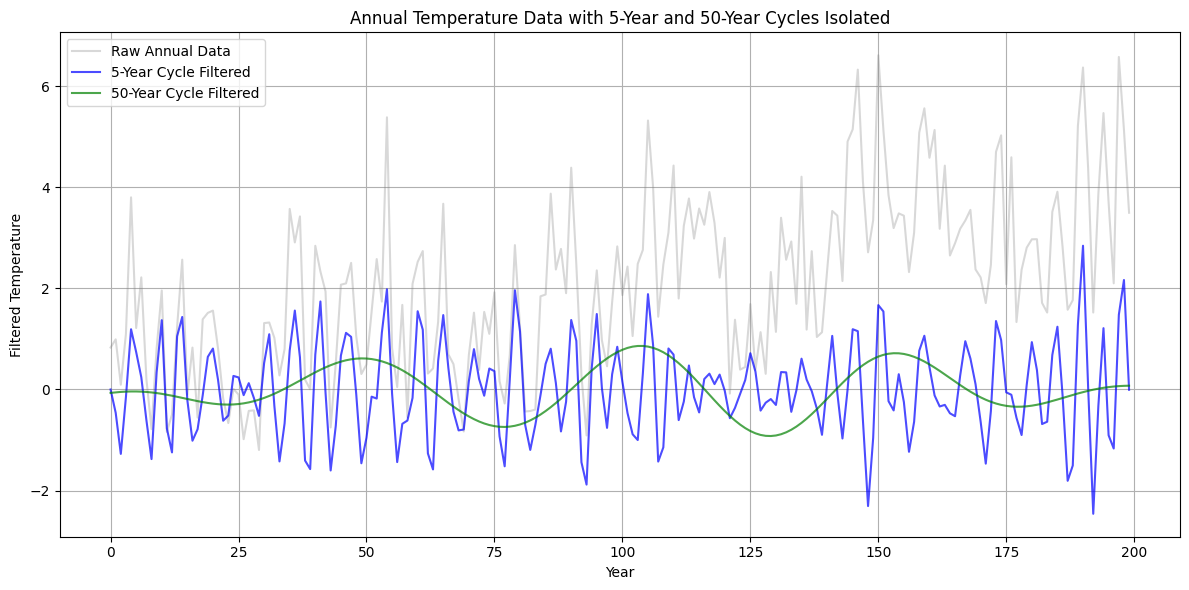

In [15]:
# Apply the bandpass filters to the annual data
filtered_temp_5yr = bandpass_filter(annual_data, low_cut_5yr, high_cut_5yr)
filtered_temp_50yr = bandpass_filter(annual_data, low_cut_50yr, high_cut_50yr)

# Plot the results for both cycles
plt.figure(figsize=(12, 6))
# Plot the raw annual data
plt.plot(np.arange(len(annual_data)), annual_data, color='gray', alpha=0.3, label='Raw Annual Data')
# Plot the filtered data for the 5-year and 50-year cycles
plt.plot(np.arange(len(annual_data)), filtered_temp_5yr, label='5-Year Cycle Filtered', color='blue', alpha=0.7)
plt.plot(np.arange(len(annual_data)), filtered_temp_50yr, label='50-Year Cycle Filtered', color='green', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Filtered Temperature')
plt.title('Annual Temperature Data with 5-Year and 50-Year Cycles Isolated')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---
**_Aside_**: *Let's play with the cutoff frequencies and check the effect of lengthening or shortening the bandwidths on the bandpassed filtered data.*

---

---
## **What Have We Learned Today?**

- **Spectral Analysis**

 Used to identify periodic components in time series data by transforming it into the frequency domain using the Discrete Fourier Transform (DFT). The power spectrum represents the strength of different frequencies in the data.

- **Red Noise and AR(1) Models**

 Red noise is often observed in climate data, and can be modeled as a random walk (AR(1) process), where each value depends on its previous value and some randomness, leading to long-term dependencies in the data.

- **Monte Carlo Significance Testing**

  Monte Carlo simulations are used to assess the statistical significance of observed spectral features by comparing the power spectrum of actual data with random realizations of red noise from the theoretical AR(1) spectrum.

- **Bandpass Filtering**

  Bandpass filters isolate specific frequency ranges, and it's a useful tool for removing unwanted noise.

---



---

### **Suggested References**:
- Meyers, Stephen R., Bradley B. Sageman, and Mark Pagani. "Resolving Milankovitch: Consideration of signal and noise." American Journal of Science 308.6 (2008): 770-786.
- Mudelsee, Manfred. Climate time series analysis. Springer, 2013.
- Schulz, M. and Mudelsee, M., 2002. REDFIT: estimating red-noise spectra directly from unevenly spaced paleoclimatic time series. Computers & Geosciences, 28(3), pp.421-426.
- Osborn, Timothy J., and Keith R. Briffa. "The real color of climate change?." Science 306.5696 (2004): 621-622.

---

### **Online Resources**

If you're curious about a cool application of some of the techniques discussed in this tutorial, check out this post by Ed Hawkings (https://www.climate-lab-book.ac.uk/2014/signal-noise-emergence/).

Also, this is a great Python package geared toward analysis of paleoclimate timeseries including a variety of spectral analysis techniques (https://pyleoclim-util.readthedocs.io/en/latest/).

For a comprehensive overview on Digital Signal Theory, I recommend this online book (https://brianmcfee.net/dstbook-site/content/intro.html)

---

## Glossary

| Term                        | Definition                                                                                                                                                                                                          |
|-----------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Spectral Analysis**       | A technique used to decompose a time series into its constituent frequencies, allowing us to identify periodic patterns and trends within the data.                                                                   |
| **Fourier Transform**       | A mathematical tool that converts a time-domain signal into its frequency-domain representation, revealing the frequencies present in the signal.                                                                   |
| **Power Spectrum**         | A plot showing the strength (power) of different frequencies within a signal. Peaks in the power spectrum indicate dominant frequencies or periodicities.                                                            |
| **Periodogram**             | An estimate of the power spectrum of a signal, often calculated using the Fast Fourier Transform (FFT).                                                                                                        |
| **Frequency**              | The rate at which a signal repeats itself, measured in cycles per unit of time (e.g., cycles per year).                                                                                                           |
| **Period**                 | The time it takes for one complete cycle of a signal to occur (e.g., the period of an annual cycle is 1 year).                                                                                                    |
| **Stationarity**           | A property of a time series where its statistical properties (mean, variance, autocorrelation) remain constant over time. Spectral analysis methods often assume stationarity.                                      |
| **Autocorrelation**          | The correlation of a signal with a lagged copy of itself, indicating how much the signal's current value is influenced by its past values.                                                                     |
| **Red Noise**              | A type of noise with more power at lower frequencies, often observed in climate data due to persistence and memory in the climate system. Also known as a random walk or an AR(1) process.                             |
| **White Noise**            | A type of noise with equal power at all frequencies, representing random and uncorrelated fluctuations.                                                                                                          |
| **AR(1) Process**           | An autoregressive model of order 1, where the current value of a time series depends on its previous value and a random error term.                                                                              |
| **Monte Carlo Simulation** | A computational technique that uses repeated random sampling to estimate the probability distribution of a statistic or to assess the significance of an observed result.                                         |
| **Spectral Leakage**       | The spreading of power from one frequency to neighboring frequencies in a power spectrum, often caused by edge effects or noise in the data.                                                                     |
| **Windowing**              | A technique used to reduce spectral leakage by applying a weighting function (window) to the data before calculating the power spectrum.                                                                          |
| **Bandpass Filter**        | A filter that allows frequencies within a specific range (band) to pass through while attenuating frequencies outside that range. Useful for isolating specific cycles or phenomena in a signal.                   |
| **Nyquist Frequency**      | The highest frequency that can be accurately resolved in a signal, equal to half the sampling rate. Frequencies above the Nyquist frequency are aliased (appear as lower frequencies in the spectrum). |

---
## Appendix: Code Explanation and Resources

1. Periodogram Function

In [ ]:
from scipy.signal import periodogram

f, Pxx = periodogram(data, fs=1/dt, window='hann')

- `data`: The input time series data.
- `fs`: The sampling frequency (1/dt, where dt is the time step).
- `window`: The window function used to reduce spectral leakage (e.g., 'hann', 'hamming', 'boxcar', 'blackman').
- `f`: The array of frequencies.
- `Pxx`: The power spectrum (power at each frequency).

---



**2. Autoregressive (AR) Model**

This is an alternative method to estimate an AR(1) model using the `statsmodels` library in Python.

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(data, lags=1)  # Fit an AR(1) model
results = model.fit()          # Get model results
alpha = results.params[1]     # Extract the AR(1) coefficient

- `data`: The input time series data.
- `lags`: The order of the autoregressive model (1 for AR(1)).
- `alpha`: The estimated AR(1) coefficient, representing the persistence of the process.

---

**3. Butterworth Filter**

In [ ]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, low_cut, high_cut, fs=1/dt, order=4):
    nyquist = 0.5 * fs
    low = low_cut / nyquist
    high = high_cut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

- `data`: The input time series data.
- `low_cut`: The lower cutoff frequency of the bandpass filter.
- `high_cut`: The upper cutoff frequency of the bandpass filter.
- `fs`: The sampling frequency.
- `order`: The order of the Butterworth filter.